In [2]:
!pip install optuna efficientnet_pytorch

Defaulting to user installation because normal site-packages is not writeable
  Using cached optuna-4.3.0-py3-none-any.whl.metadata (17 kB)
  Using cached efficientnet_pytorch-0.7.1-py3-none-any.whl
  Using cached alembic-1.16.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached sqlalchemy-2.0.41-cp313-cp313-win_amd64.whl.metadata (9.8 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)
  Using cached greenlet-3.2.3-cp313-cp313-win_amd64.whl.metadata (4.2 kB)
Using cached optuna-4.3.0-py3-none-any.whl (386 kB)
Using cached alembic-1.16.1-py3-none-any.whl (242 kB)
Using cached sqlalchemy-2.0.41-cp313-cp313-win_amd64.whl (2.1 MB)
Using cached greenlet-3.2.3-cp313-cp313-win_amd64.whl (297 kB)
Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)
Using cached mako-1.3.10-py3-none-any.whl (78 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

   ------

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import optuna
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import ImageFile

In [4]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_dir = "C:/Project/DR/"



batch_size = 128
num_classes = 5

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor()
])


dataset = datasets.ImageFolder(data_dir)

# Manual split using indices
train_loader = int(0.5 * len(dataset))
val_loader = int(0.25 * len(dataset))
test_loader = len(dataset) - train_loader - val_loader

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_loader, val_loader, test_loader])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Apply different transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform




In [6]:
dataset.classes

['Mild_NPDR', 'Moderate_NPDR', 'No_DR', 'PDR', 'Severe_NPDR']

In [7]:
from collections import Counter

# Load dataset
dataset = datasets.ImageFolder(data_dir)

# ✅ Check for class imbalance
labels = [label for _, label in dataset.imgs]
class_counts = Counter(labels)
print("Class distribution:", class_counts)


Class distribution: Counter({3: 49, 1: 48, 2: 48, 4: 48, 0: 20})


In [8]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [9]:
import random
import numpy as np

class AGMCSOptimizer:
    def __init__(self, population_size, generations, train_loader, val_loader, num_classes, model_type='resnet'):
        self.population_size = population_size
        self.generations = generations
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.num_classes = num_classes
        self.model_type = model_type  # 'resnet' or 'densenet'

        # Initialize population with random candidates (lr, momentum)
        self.population = []
        self.init_population()

    def init_population(self):
        for _ in range(self.population_size):
            candidate = {
                "lr": 10 ** random.uniform(-5, -2),  # log uniform between 1e-5 and 1e-2
                "momentum": random.uniform(0.5, 0.99),
                "fitness": float('inf')  # Lower fitness better (1-accuracy)
            }
            self.population.append(candidate)

    def optimize(self):
        for gen in range(self.generations):
            print(f"Generation {gen+1}/{self.generations}")
            for candidate in self.population:
                # Run the objective function with candidate hyperparameters
                if self.model_type == 'resnet':
                    fitness = objective_resnet_with_params(candidate["lr"], candidate["momentum"], self.train_loader, self.val_loader, self.num_classes)
                else:
                    fitness = objective_densenet_with_params(candidate["lr"], candidate["momentum"], self.train_loader, self.val_loader, self.num_classes)

                candidate["fitness"] = fitness
                print(f"lr: {candidate['lr']:.5f}, momentum: {candidate['momentum']:.3f}, fitness (1-acc): {fitness:.4f}")

            # Sort population by fitness (lower is better)
            self.population.sort(key=lambda x: x["fitness"])

            # AGM-CS inspired update:
            half = self.population_size // 2
            best_half = self.population[:half]
            worst_half = self.population[half:]

            for i in range(half):
                parent = best_half[i % half]
                worst_half[i]["lr"] = self.perturb(parent["lr"], 1e-5, 1e-2)
                worst_half[i]["momentum"] = self.perturb(parent["momentum"], 0.5, 0.99)
                worst_half[i]["fitness"] = float('inf')  # reset fitness

            print(f"Best candidate this gen: lr={self.population[0]['lr']:.5f}, momentum={self.population[0]['momentum']:.3f}, fitness={self.population[0]['fitness']:.4f}")

        return self.population[0]

    def perturb(self, value, min_val, max_val, scale=0.1):
        change = value * scale * (random.random() * 2 - 1)
        new_value = value + change
        return max(min_val, min(max_val, new_value))


# Helper functions wrapping your objective to accept hyperparams directly
def objective_resnet_with_params(lr, momentum, train_loader, val_loader, num_classes):
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = True

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.fc.parameters(), lr=lr, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

    model.train()
    for epoch in range(5):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return 1 - accuracy  # minimize 1-accuracy


def objective_densenet_with_params(lr, momentum, train_loader, val_loader, num_classes):
    model = models.densenet121(pretrained=True)
    for param in model.parameters():
        param.requires_grad = True

    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.classifier.parameters(), lr=lr, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

    model.train()
    for epoch in range(5):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return 1 - accuracy  # minimize 1-accuracy


In [10]:
from functools import partial

# This is the actual Optuna-compatible wrapper
def optuna_objective_resnet(trial, train_loader, val_loader, num_classes):
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    momentum = trial.suggest_uniform("momentum", 0.5, 0.99)
    return objective_resnet_with_params(lr, momentum, train_loader, val_loader, num_classes)

# Wrap with partial to pass extra args
objective_resnet_partial = partial(
    optuna_objective_resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=num_classes
)



In [ ]:
# Run optimization
study_resnet = optuna.create_study(direction="minimize")
study_resnet.optimize(objective_resnet_partial, n_trials=10)

[I 2025-06-09 22:57:17,638] A new study created in memory with name: no-name-a6d040dc-77f7-4d81-b0f2-53c31b7f60e6
C:\Users\PC\AppData\Local\Temp\ipykernel_19024\2151569771.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
C:\Users\PC\AppData\Local\Temp\ipykernel_19024\2151569771.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform("momentum", 0.5, 0.99)
C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PC\AppData

In [ ]:
def optuna_objective_densenet(trial, train_loader, val_loader, num_classes):
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    momentum = trial.suggest_uniform("momentum", 0.5, 0.99)
    return objective_densenet_with_params(lr, momentum, train_loader, val_loader, num_classes)

objective_densenet_partial = partial(
    optuna_objective_densenet,
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=num_classes
)

study_densenet = optuna.create_study(direction="minimize")
study_densenet.optimize(objective_densenet_partial, n_trials=10)



[I 2025-06-09 23:03:11,514] A new study created in memory with name: no-name-5470a460-3909-44d7-a4a9-67d20d10e05d
C:\Users\PC\AppData\Local\Temp\ipykernel_19024\2683741235.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
C:\Users\PC\AppData\Local\Temp\ipykernel_19024\2683741235.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform("momentum", 0.5, 0.99)
C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalen

In [13]:
best_resnet_params = study_resnet.best_params
best_densenet_params = study_densenet.best_params

print("Best parameters for ResNet:", best_resnet_params)
print("Best parameters for DenseNet:", best_densenet_params)

Best parameters for ResNet: {'lr': 0.00024203397107275108, 'momentum': 0.7896915330870753}
Best parameters for DenseNet: {'lr': 0.000788348554304499, 'momentum': 0.9857098753979573}


In [14]:
# Train the best ResNet model
lr_resnet = best_resnet_params["lr"]
momentum_resnet = best_resnet_params["momentum"]

resnet_model = models.resnet18(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = True
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model = resnet_model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_resnet = optim.SGD(resnet_model.fc.parameters(), lr=lr_resnet, momentum=momentum_resnet)

train_losses_resnet = []
val_losses_resnet = []
train_accuracies_resnet = []
val_accuracies_resnet = []

for epoch in range(50):
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_resnet.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = correct / total
    train_losses_resnet.append(epoch_train_loss)
    train_accuracies_resnet.append(epoch_train_accuracy)

    resnet_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = val_correct / val_total
    val_losses_resnet.append(epoch_val_loss)
    val_accuracies_resnet.append(epoch_val_accuracy)

In [15]:
# Train the best DenseNet model
lr_densenet = best_densenet_params["lr"]
momentum_densenet = best_densenet_params["momentum"]

densenet_model = models.densenet121(pretrained=True)
for param in densenet_model.parameters():
    param.requires_grad = True
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, num_classes)
densenet_model = densenet_model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_densenet = optim.SGD(densenet_model.classifier.parameters(), lr=lr_densenet, momentum=momentum_densenet)

train_losses_densenet = []
val_losses_densenet = []
train_accuracies_densenet = []
val_accuracies_densenet = []

for epoch in range(50):
    densenet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_densenet.zero_grad()
        outputs = densenet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_densenet.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = correct / total
    train_losses_densenet.append(epoch_train_loss)
    train_accuracies_densenet.append(epoch_train_accuracy)

    densenet_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = densenet_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = val_correct / val_total
    val_losses_densenet.append(epoch_val_loss)
    val_accuracies_densenet.append(epoch_val_accuracy)

In [16]:
# Evaluate and compare the models
def evaluate_model(model, loader, model_name):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=dataset.classes)
    print(f"Classification Report for {model_name}:")
    print(report)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

Classification Report for ResNet:
               precision    recall  f1-score   support

    Mild_NPDR       0.00      0.00      0.00         4
Moderate_NPDR       0.25      0.15      0.19        13
        No_DR       0.30      0.60      0.40        15
          PDR       0.27      0.23      0.25        13
  Severe_NPDR       0.20      0.11      0.14         9

     accuracy                           0.28        54
    macro avg       0.20      0.22      0.20        54
 weighted avg       0.24      0.28      0.24        54



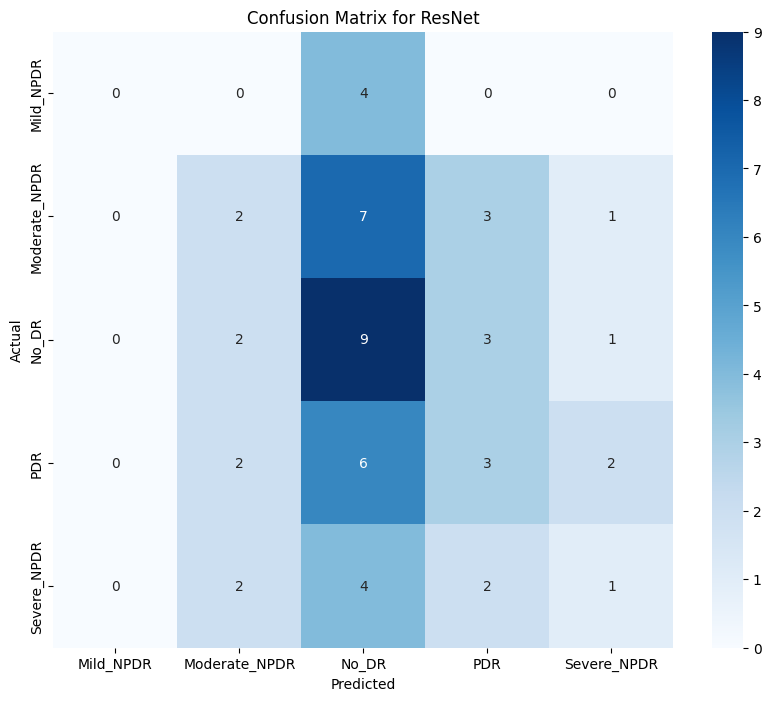

In [17]:
# Evaluate ResNet
evaluate_model(resnet_model, test_loader, "ResNet")
torch.save(resnet_model, 'resnet.pth')

Classification Report for DenseNet:
               precision    recall  f1-score   support

    Mild_NPDR       0.20      0.50      0.29         4
Moderate_NPDR       0.38      0.38      0.38        13
        No_DR       0.71      0.67      0.69        15
          PDR       0.53      0.62      0.57        13
  Severe_NPDR       1.00      0.22      0.36         9

     accuracy                           0.50        54
    macro avg       0.57      0.48      0.46        54
 weighted avg       0.60      0.50      0.50        54



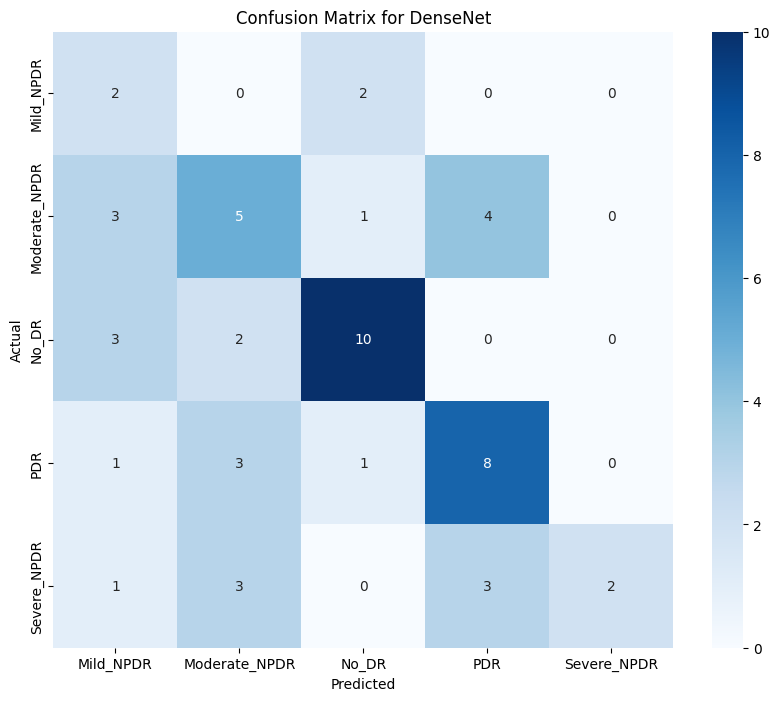

In [18]:
# Evaluate DenseNet
evaluate_model(densenet_model, test_loader, "DenseNet")
torch.save(densenet_model, 'densenet.pth')

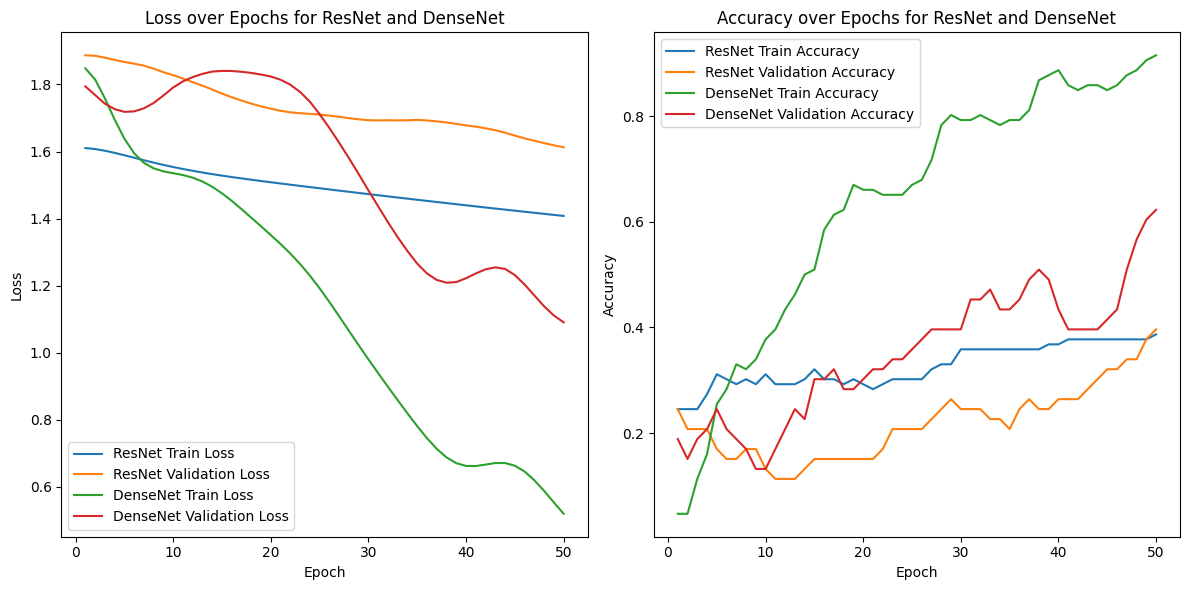

In [19]:
# Plot loss and accuracy for both models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 51), train_losses_resnet, label="ResNet Train Loss")
plt.plot(range(1, 51), val_losses_resnet, label="ResNet Validation Loss")
plt.plot(range(1, 51), train_losses_densenet, label="DenseNet Train Loss")
plt.plot(range(1, 51), val_losses_densenet, label="DenseNet Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs for ResNet and DenseNet")

plt.subplot(1, 2, 2)
plt.plot(range(1, 51), train_accuracies_resnet, label="ResNet Train Accuracy")
plt.plot(range(1, 51), val_accuracies_resnet, label="ResNet Validation Accuracy")
plt.plot(range(1, 51), train_accuracies_densenet, label="DenseNet Train Accuracy")
plt.plot(range(1, 51), val_accuracies_densenet, label="DenseNet Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs for ResNet and DenseNet")

plt.tight_layout()
plt.show()

In [35]:
!pip install efficientnet_pytorch

Defaulting to user installation because normal site-packages is not writeable


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
import optuna

class EfficientNetClassifier(nn.Module):
    def __init__(self, n_classes):
        super(EfficientNetClassifier, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b3')
        self.base_model._fc = nn.Identity()  # Remove final FC layer

        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1536, momentum=0.999, eps=0.001),
            nn.Linear(1536, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.base_model.extract_features(x)
        x = self.base_model._avg_pooling(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

def objective_efficientnet(trial):
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    momentum = trial.suggest_uniform("momentum", 0.5, 0.99)

    model = EfficientNetClassifier(n_classes=5)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    model.train()
    for epoch in range(5):  # Use more epochs in real tuning
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return 1 - accuracy

In [21]:
study_efficientnet = optuna.create_study()
study_efficientnet.optimize(objective_efficientnet, n_trials=10)

[I 2025-06-10 00:24:18,425] A new study created in memory with name: no-name-4d486db4-9e87-4b3e-8b67-f10bbbdd617c
C:\Users\PC\AppData\Local\Temp\ipykernel_19024\2762663672.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
C:\Users\PC\AppData\Local\Temp\ipykernel_19024\2762663672.py:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform("momentum", 0.5, 0.99)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to C:\Users\PC/.cache\torch\hub\checkpoints\efficientnet-b3-5fb5a3c3.pth


[W 2025-06-10 00:24:21,899] Trial 0 failed with parameters: {'lr': 3.021710198515483e-05, 'momentum': 0.5104995401661029} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\PC\AppData\Local\Temp\ipykernel_19024\2762663672.py", line 37, in objective_efficientnet
    model = EfficientNetClassifier(n_classes=5)
  File "C:\Users\PC\AppData\Local\Temp\ipykernel_19024\2762663672.py", line 10, in __init__
    self.base_model = EfficientNet.from_pretrained('efficientnet-b3')
                      ~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\efficientnet_pytorch\model.py", line 378, in from_pretrained
    load_pretrained_weights(model, model_name, weights_path=weights_path,
    ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [19]:
best_efficientnet_params = study_efficientnet.best_params
print("Best parameters for efficientnet:", best_efficientnet_params)

Best parameters for efficientnet: {'lr': 0.0007807050694743203, 'momentum': 0.6209500110353777}


In [20]:
lr_effnet = best_efficientnet_params["lr"]
momentum_effnet = best_efficientnet_params["momentum"]

model_effnet = EfficientNetClassifier(n_classes=5)
model_effnet = model_effnet.to(device)

# Define loss and optimizer
criterion_effnet = nn.CrossEntropyLoss()
optimizer_effnet = optim.SGD(model_effnet.parameters(), lr=lr_effnet, momentum=momentum_effnet)

# Metrics tracking
train_losses_effnet = []
val_losses_effnet = []
train_accuracies_effnet = []
val_accuracies_effnet = []

for epoch in range(50):  # Increase or tune based on need
    model_effnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_effnet.zero_grad()
        outputs = model_effnet(inputs)
        loss = criterion_effnet(outputs, labels)
        loss.backward()
        optimizer_effnet.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = correct / total
    train_losses_effnet.append(epoch_train_loss)
    train_accuracies_effnet.append(epoch_train_accuracy)

    # Validation
    model_effnet.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_effnet(inputs)
            loss = criterion_effnet(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = val_correct / val_total
    val_losses_effnet.append(epoch_val_loss)
    val_accuracies_effnet.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_accuracy:.4f}, "
          f"Val Loss={epoch_val_loss:.4f}, Val Acc={epoch_val_accuracy:.4f}")

Loaded pretrained weights for efficientnet-b3
Epoch 1: Train Loss=1.6080, Train Acc=0.1875, Val Loss=1.5869, Val Acc=0.4375
Epoch 2: Train Loss=1.6062, Train Acc=0.2222, Val Loss=1.5872, Val Acc=0.4375
Epoch 3: Train Loss=1.6008, Train Acc=0.2431, Val Loss=1.5831, Val Acc=0.4375
Epoch 4: Train Loss=1.5969, Train Acc=0.2778, Val Loss=1.5814, Val Acc=0.4375
Epoch 5: Train Loss=1.5923, Train Acc=0.2604, Val Loss=1.5779, Val Acc=0.4375
Epoch 6: Train Loss=1.5903, Train Acc=0.2569, Val Loss=1.5810, Val Acc=0.4375
Epoch 7: Train Loss=1.5840, Train Acc=0.2743, Val Loss=1.5773, Val Acc=0.4375
Epoch 8: Train Loss=1.5795, Train Acc=0.2917, Val Loss=1.5753, Val Acc=0.4375
Epoch 9: Train Loss=1.5794, Train Acc=0.3472, Val Loss=1.5755, Val Acc=0.4062
Epoch 10: Train Loss=1.5681, Train Acc=0.3576, Val Loss=1.5710, Val Acc=0.4375
Epoch 11: Train Loss=1.5652, Train Acc=0.3646, Val Loss=1.5696, Val Acc=0.4375
Epoch 12: Train Loss=1.5690, Train Acc=0.3264, Val Loss=1.5672, Val Acc=0.4688
Epoch 13: Train

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for EfficientNet:
               precision    recall  f1-score   support

    Mild_NPDR       0.00      0.00      0.00         1
Moderate_NPDR       0.33      0.45      0.38        11
        No_DR       0.53      1.00      0.69         9
          PDR       0.00      0.00      0.00         5
  Severe_NPDR       0.00      0.00      0.00         6

     accuracy                           0.44        32
    macro avg       0.17      0.29      0.22        32
 weighted avg       0.26      0.44      0.33        32



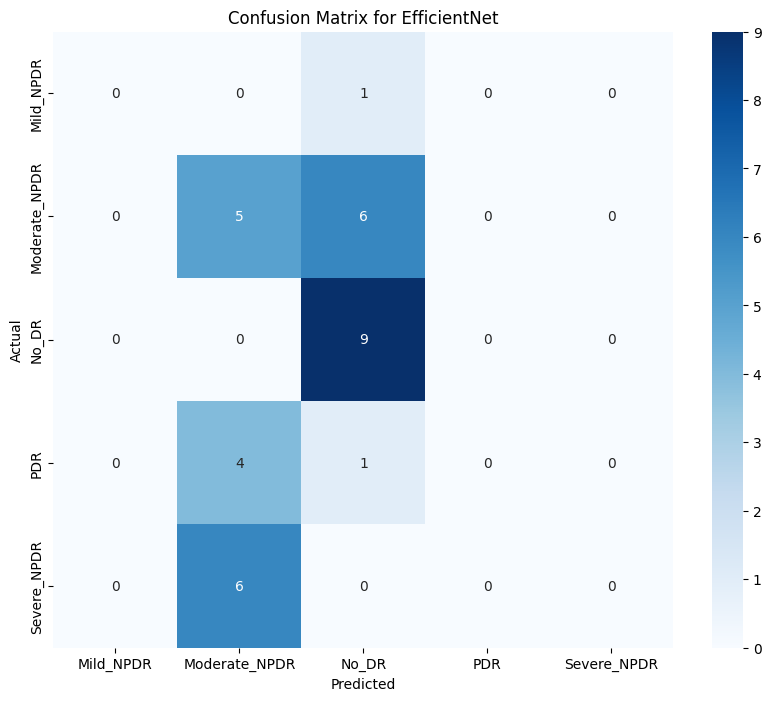

In [21]:
evaluate_model(model_effnet, test_loader, "EfficientNet")
torch.save(model_effnet, 'efficientnet.pth')

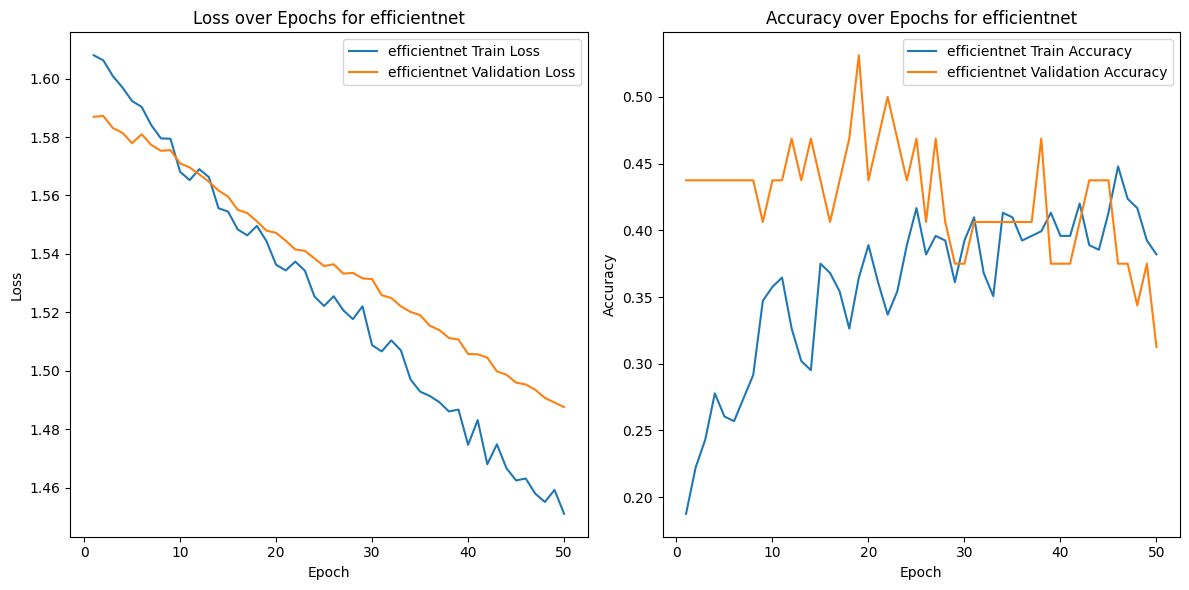

In [22]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 51), train_losses_effnet, label="efficientnet Train Loss")
plt.plot(range(1, 51), val_losses_effnet, label="efficientnet Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs for efficientnet")

plt.subplot(1, 2, 2)
plt.plot(range(1, 51), train_accuracies_effnet, label="efficientnet Train Accuracy")
plt.plot(range(1, 51), val_accuracies_effnet, label="efficientnet Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs for efficientnet")

plt.tight_layout()
plt.show()

Loaded pretrained weights for efficientnet-b3
Epoch 1/50, Train Acc: 0.3212, Val Acc: 0.3976
Epoch 2/50, Train Acc: 0.3667, Val Acc: 0.4578
Epoch 3/50, Train Acc: 0.4333, Val Acc: 0.5422
Epoch 4/50, Train Acc: 0.4879, Val Acc: 0.5542
Epoch 5/50, Train Acc: 0.4667, Val Acc: 0.5783
Epoch 6/50, Train Acc: 0.5091, Val Acc: 0.5542
Epoch 7/50, Train Acc: 0.5606, Val Acc: 0.4217
Epoch 8/50, Train Acc: 0.5667, Val Acc: 0.4096
Epoch 9/50, Train Acc: 0.6091, Val Acc: 0.3976
Epoch 10/50, Train Acc: 0.6242, Val Acc: 0.5422
Epoch 11/50, Train Acc: 0.6758, Val Acc: 0.6024
Epoch 12/50, Train Acc: 0.7152, Val Acc: 0.5301
Epoch 13/50, Train Acc: 0.7182, Val Acc: 0.5060
Epoch 14/50, Train Acc: 0.7667, Val Acc: 0.5663
Epoch 15/50, Train Acc: 0.7788, Val Acc: 0.5783
Epoch 16/50, Train Acc: 0.7848, Val Acc: 0.7108
Epoch 17/50, Train Acc: 0.7939, Val Acc: 0.5663
Epoch 18/50, Train Acc: 0.8212, Val Acc: 0.6145
Epoch 19/50, Train Acc: 0.8242, Val Acc: 0.6145
Epoch 20/50, Train Acc: 0.8727, Val Acc: 0.5542
Epo

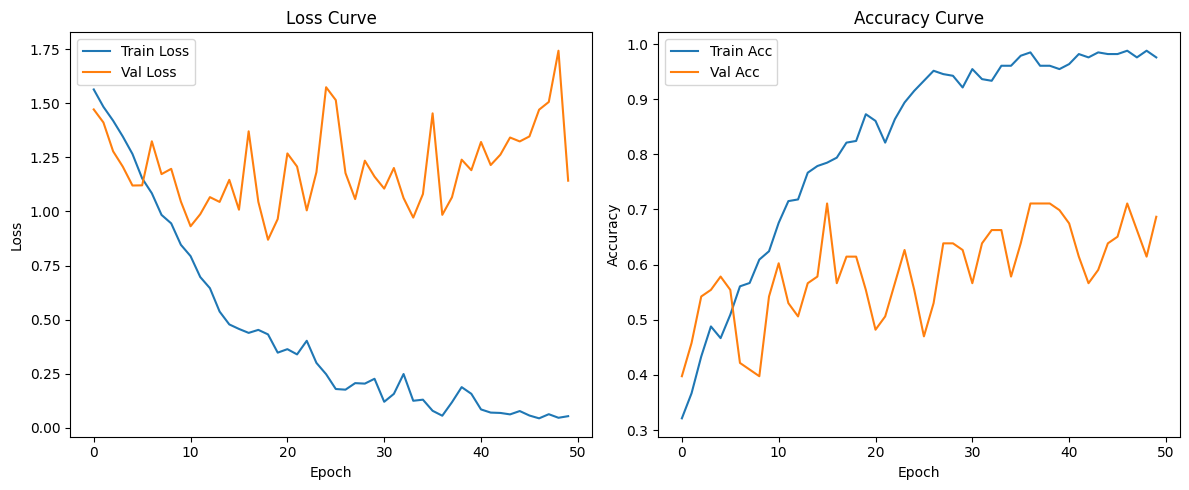

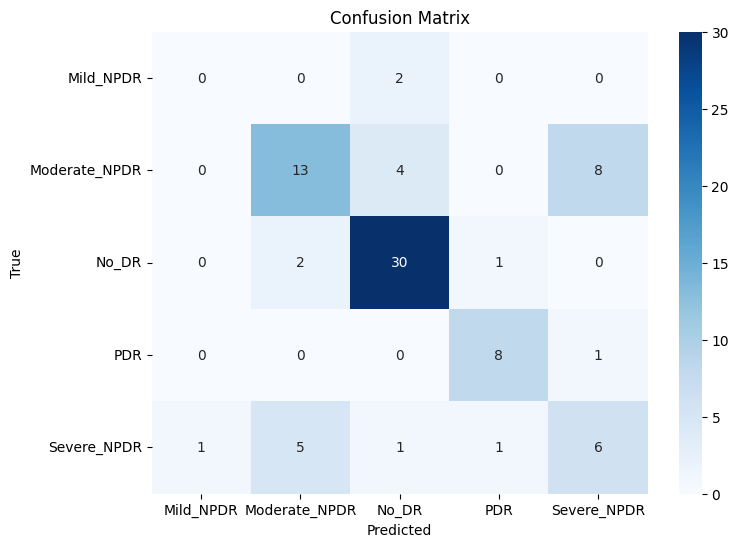

Classification Report:
               precision    recall  f1-score   support

    Mild_NPDR       0.00      0.00      0.00         2
Moderate_NPDR       0.65      0.52      0.58        25
        No_DR       0.81      0.91      0.86        33
          PDR       0.80      0.89      0.84         9
  Severe_NPDR       0.40      0.43      0.41        14

     accuracy                           0.69        83
    macro avg       0.53      0.55      0.54        83
 weighted avg       0.67      0.69      0.68        83



In [23]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from efficientnet_pytorch import EfficientNet
from skimage.feature import graycomatrix, graycoprops
from PIL import Image
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CombinedDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        path, label = self.dataset.samples[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image_tensor = self.transform(image)
        gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
        glcm = graycomatrix(gray, distances=[1], angles=[0], symmetric=True, normed=True)
        glcm_feats = [
            graycoprops(glcm, 'contrast')[0, 0],
            graycoprops(glcm, 'dissimilarity')[0, 0],
            graycoprops(glcm, 'homogeneity')[0, 0],
            graycoprops(glcm, 'energy')[0, 0],
            graycoprops(glcm, 'correlation')[0, 0],
            graycoprops(glcm, 'ASM')[0, 0],
        ]
        glcm_feats = torch.tensor(glcm_feats, dtype=torch.float32)
        return image_tensor, glcm_feats, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

full_dataset = CombinedDataset(root_dir='/kaggle/input/idrid-grading-dataset/DR_Training_Set', transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
n_classes = len(full_dataset.dataset.classes)

class CombinedClassifier(nn.Module):
    def __init__(self, n_classes):
        super(CombinedClassifier, self).__init__()
        self.base_model = EfficientNetClassifier(n_classes=5)
        self.base_model = torch.load(r'/kaggle/working/efficientnet.pth', map_location=device, weights_only=False)
        self.base_model.classifier = nn.Identity()
        self.feature_size = 1536
        self.glcm_size = 6
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(self.feature_size + self.glcm_size, momentum=0.999, eps=0.001),
            nn.Linear(self.feature_size + self.glcm_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, n_classes)
        )

    def forward(self, x, glcm_feats):
        x = self.base_model(x)
        combined = torch.cat((x, glcm_feats), dim=1)
        return self.classifier(combined)

model = CombinedClassifier(n_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.009189495776649313, momentum=0.6159671579744513)

train_accs, val_accs, train_losses, val_losses = [], [], [], []
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for inputs, glcm_feats, labels in train_loader:
        inputs, glcm_feats, labels = inputs.to(device), glcm_feats.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, glcm_feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_accs.append(correct / total)
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_correct, val_total = 0, 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, glcm_feats, labels in val_loader:
            inputs, glcm_feats, labels = inputs.to(device), glcm_feats.to(device), labels.to(device)
            outputs = model(inputs, glcm_feats)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_accs.append(val_correct / val_total)
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_accs[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, glcm_feats, labels in val_loader:
        inputs, glcm_feats = inputs.to(device), glcm_feats.to(device)
        outputs = model(inputs, glcm_feats)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.dataset.classes, yticklabels=full_dataset.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.dataset.classes))

In [24]:
torch.save(model, 'combined_model.pth')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Train Acc: 0.3061, Val Acc: 0.4096
Epoch 2/50, Train Acc: 0.4273, Val Acc: 0.6024
Epoch 3/50, Train Acc: 0.4758, Val Acc: 0.5542
Epoch 4/50, Train Acc: 0.5030, Val Acc: 0.6145
Epoch 5/50, Train Acc: 0.5061, Val Acc: 0.5783
Epoch 6/50, Train Acc: 0.5879, Val Acc: 0.5783
Epoch 7/50, Train Acc: 0.6030, Val Acc: 0.5663
Epoch 8/50, Train Acc: 0.6818, Val Acc: 0.6145
Epoch 9/50, Train Acc: 0.7152, Val Acc: 0.6145
Epoch 10/50, Train Acc: 0.6545, Val Acc: 0.5181
Epoch 11/50, Train Acc: 0.7030, Val Acc: 0.6506
Epoch 12/50, Train Acc: 0.7606, Val Acc: 0.5663
Epoch 13/50, Train Acc: 0.7697, Val Acc: 0.5060
Epoch 14/50, Train Acc: 0.7879, Val Acc: 0.6386
Epoch 15/50, Train Acc: 0.7909, Val Acc: 0.6747
Epoch 16/50, Train Acc: 0.8242, Val Acc: 0.6747
Epoch 17/50, Train Acc: 0.8242, Val Acc: 0.5663
Epoch 18/50, Train Acc: 0.8485, Val Acc: 0.6024
Epoch 19/50, Train Acc: 0.9000, Val Acc: 0.7108
Epoch 20/50, Train Acc: 0.8788, Val Acc: 0.6627
Epoch 21/50, Train Acc: 0.8818, Val Acc: 0.4458
E

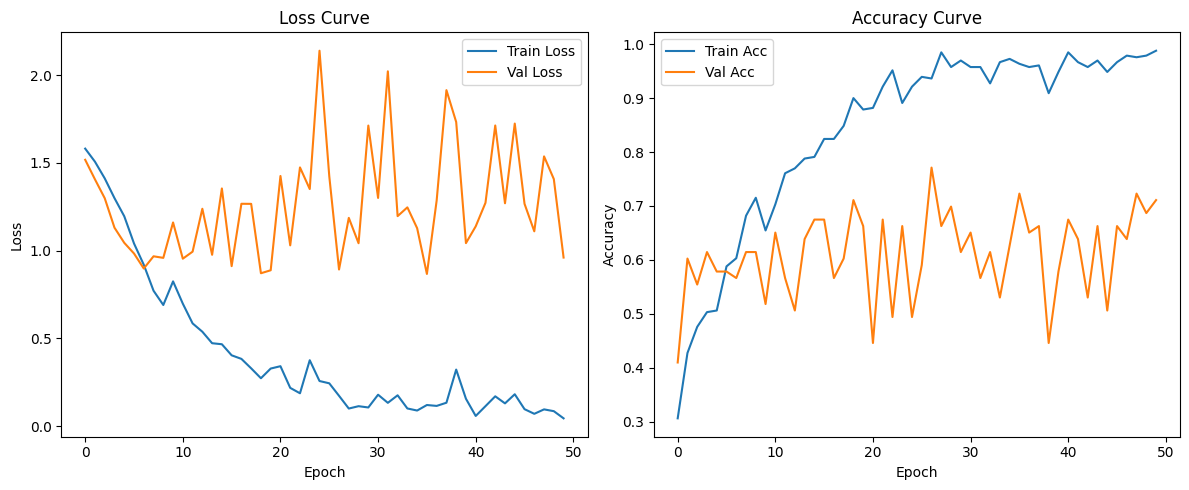

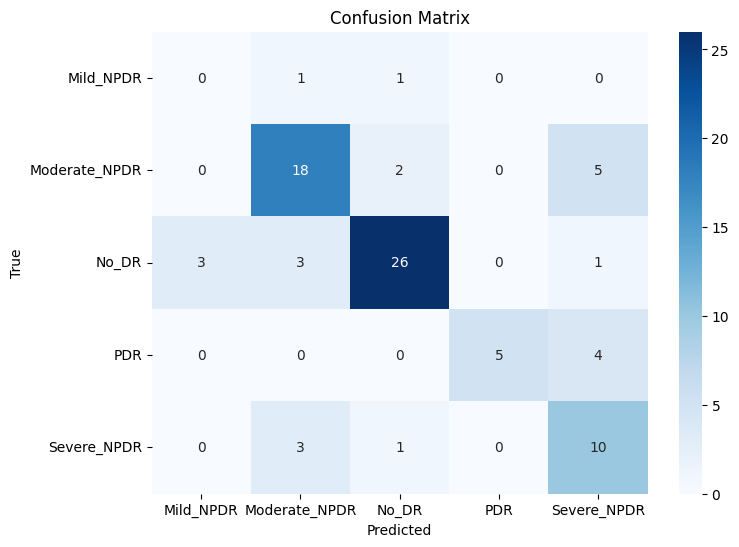

Classification Report:
               precision    recall  f1-score   support

    Mild_NPDR       0.00      0.00      0.00         2
Moderate_NPDR       0.72      0.72      0.72        25
        No_DR       0.87      0.79      0.83        33
          PDR       1.00      0.56      0.71         9
  Severe_NPDR       0.50      0.71      0.59        14

     accuracy                           0.71        83
    macro avg       0.62      0.56      0.57        83
 weighted avg       0.75      0.71      0.72        83



In [25]:
import torch
import torch.nn as nn
from torchvision import models

class CombinedClassifier(nn.Module):
    def __init__(self, n_classes):
        super(CombinedClassifier, self).__init__()
        self.base_model = models.densenet121(pretrained=True)
        self.base_model.classifier = nn.Identity()
        self.feature_size = 1024
        self.glcm_size = 6
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(self.feature_size + self.glcm_size, momentum=0.999, eps=0.001),
            nn.Linear(self.feature_size + self.glcm_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, n_classes)
        )

    def forward(self, x, glcm_feats):
        x = self.base_model(x)
        combined = torch.cat((x, glcm_feats), dim=1)
        return self.classifier(combined)

model = CombinedClassifier(n_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.009189495776649313, momentum=0.6159671579744513)

train_accs, val_accs, train_losses, val_losses = [], [], [], []
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for inputs, glcm_feats, labels in train_loader:
        inputs, glcm_feats, labels = inputs.to(device), glcm_feats.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, glcm_feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_accs.append(correct / total)
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_correct, val_total = 0, 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, glcm_feats, labels in val_loader:
            inputs, glcm_feats, labels = inputs.to(device), glcm_feats.to(device), labels.to(device)
            outputs = model(inputs, glcm_feats)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_accs.append(val_correct / val_total)
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_accs[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, glcm_feats, labels in val_loader:
        inputs, glcm_feats = inputs.to(device), glcm_feats.to(device)
        outputs = model(inputs, glcm_feats)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.dataset.classes, yticklabels=full_dataset.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.dataset.classes))

In [26]:
torch.save(model, 'combined_densenet_model.pth')